#   **Conversion of CSV into Shapefile and then into Raster.**

# Reading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

In [2]:
df=pd.read_csv(r"C:\Users\Prajwal\Desktop\Internships\Symantics\EST Yield\est_Yield.csv")
df

,Unnamed: 0,Lat,Long,Est_Yield
0,0,18.321940,76.378113,7.693439
1,1,18.321939,76.378208,9.070770
2,2,18.321939,76.378303,8.666988
3,3,18.321938,76.378397,7.870469
4,4,18.321937,76.378492,8.104672
...,...,...,...,...
1091205,1091205,18.504232,76.469825,5.460263
1091206,1091206,18.504231,76.469920,4.740299
1091207,1091207,18.504230,76.470015,5.049647
1091208,1091208,18.504230,76.470109,5.670884


In [3]:
del df['Unnamed: 0']

# Converting CSV into Shapefile using geopandas

In [4]:
shapefile= gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['Long'],df['Lat']))
shapefile

,Lat,Long,Est_Yield,geometry
0,18.321940,76.378113,7.693439,POINT (76.37811 18.32194)
1,18.321939,76.378208,9.070770,POINT (76.37821 18.32194)
2,18.321939,76.378303,8.666988,POINT (76.37830 18.32194)
3,18.321938,76.378397,7.870469,POINT (76.37840 18.32194)
4,18.321937,76.378492,8.104672,POINT (76.37849 18.32194)
...,...,...,...,...
1091205,18.504232,76.469825,5.460263,POINT (76.46983 18.50423)
1091206,18.504231,76.469920,4.740299,POINT (76.46992 18.50423)
1091207,18.504230,76.470015,5.049647,POINT (76.47001 18.50423)
1091208,18.504230,76.470109,5.670884,POINT (76.47011 18.50423)


In [5]:
print(shapefile.crs)

None


# Plotting

<AxesSubplot:>

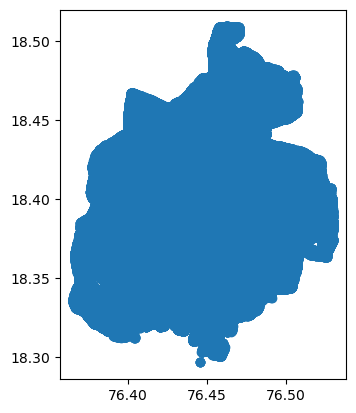

In [15]:
shapefile.plot()

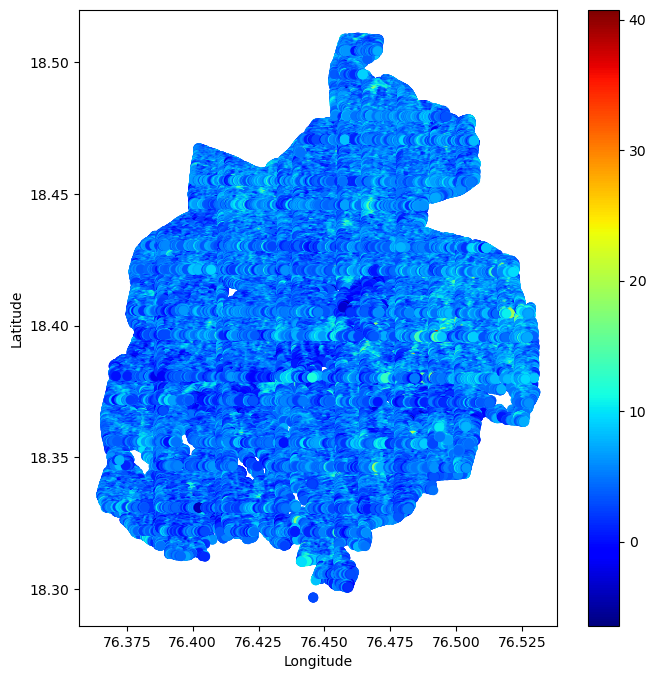

In [16]:
fig, ax = plt.subplots(1,figsize=(8,8))
shapefile.plot(ax=ax,column='Est_Yield',cmap='jet',legend=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Converting Shapefile into Raster using gdal

In [6]:
from osgeo import gdal, ogr, osr

In [7]:
input_shp=ogr.Open(r'C:\Users\Prajwal\Desktop\Internships\Symantics\EST Yield\Yield Output Shapefile')
source_layer = input_shp.GetLayer()
defn = source_layer.GetLayerDefn()
column_names = []
for i in range(defn.GetFieldCount()):
    fdefn = defn.GetFieldDefn(i)
    column_names.append(fdefn.name)

In [8]:
column_names

['Lat', 'Long', 'Est_Yield']

In [9]:
output_raster_location = r'C:\Users\Prajwal\Desktop\Internships\Symantics\EST Yield\Yield Output Raster.tif'
pixel_size = 0.000325872
xmin, xmax, ymin, ymax = source_layer.GetExtent()
x_res = int(round((xmax-xmin)/pixel_size))
y_res = int(round((ymax-ymin)/pixel_size))
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location,x_res,y_res,1,gdal.GDT_Float32,['COMPRESS=LZW'])
target_ds.SetGeoTransform((xmin,pixel_size,0.0,ymax,0.0,-pixel_size))
srse = osr.SpatialReference()
proj = 'EPSG:4326'
srse.SetWellKnownGeogCS(proj)
target_ds.SetProjection(srse.ExportToWkt())
band = target_ds.GetRasterBand(1)
target_ds.GetRasterBand(1).SetNoDataValue(-9999)
band.Fill(-9999)
gdal.RasterizeLayer(target_ds,[1],source_layer,None,None,[1],options = ['ALL_TOUCHED=TRUE','ATTRIBUTE=Est_Yield'])
target_ds = None

# Open raster by rioxarray

In [10]:
import rioxarray as rxr

In [11]:
raster = rxr.open_rasterio(output_raster_location).squeeze()

In [12]:
raster

<xarray.DataArray (y: 652, x: 506)>
[329912 values with dtype=float32]
Coordinates:
    band         int32 1
  * x            (x) float64 76.37 76.37 76.37 76.37 ... 76.53 76.53 76.53 76.53
  * y            (y) float64 18.51 18.51 18.51 18.51 ... 18.3 18.3 18.3 18.3
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [13]:
raster.shape

(652, 506)

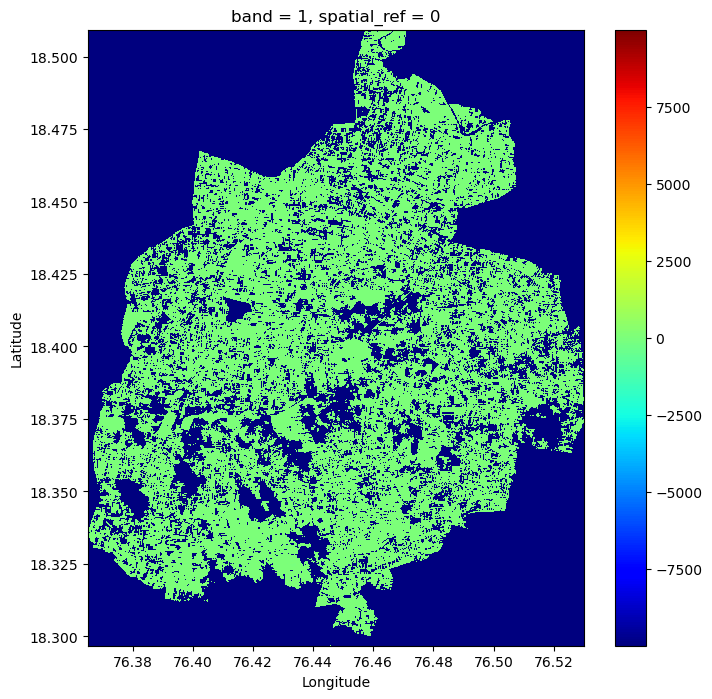

In [17]:
fig,ax = plt.subplots(1,figsize=(8,8))
raster.plot.imshow(cmap='jet')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()